In [358]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os
import keras_tuner as kt


In [359]:
print("GPUs available:", tf.config.list_physical_devices('GPU'))

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [360]:
# -------------------------
# 1. Load and preprocess data
# -------------------------

# Change the store and product for each forecast
store = 1096
product = 8011001

data_2017 = f"Magaza CSV Files 2017/magaza_{store}_2017.csv"
data_2018 = f"Magaza CSV Files 2018/magaza_{store}_2018.csv"
data_2019 = f"Magaza CSV Files 2019/magaza_{store}_2019.csv"


df_2017 = pd.read_csv(data_2017)
df_2018 = pd.read_csv(data_2018)
df_2019 = pd.read_csv(data_2019)

data = pd.concat([df_2017, df_2018])
data = data.sort_values('tarih')
data.set_index('tarih', inplace=True)

sales = data[['toplam_satis_adet']]

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sales = scaler.fit_transform(sales)

print(data.head(10))

            magaza_no   mal_no  toplam_satis_tl  toplam_satis_adet
tarih                                                             
2017-01-01       1096  8011001            22.93                 15
2017-01-01       1096  8011001            22.93                 15
2017-01-02       1096  8011001            32.13                 21
2017-01-02       1096  8011001            32.13                 21
2017-01-03       1096  8011001            45.86                 30
2017-01-03       1096  8011001            45.86                 30
2017-01-04       1096  8011001            44.35                 29
2017-01-04       1096  8011001            44.35                 29
2017-01-05       1096  8011001            29.05                 19
2017-01-05       1096  8011001            29.05                 19


In [361]:
# -------------------------
# 2. Create time-series dataset (sliding window)
# -------------------------
def create_dataset(series, window_size=30):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

# Define the window size (e.g., 30 days)
window_size = 30
X, y = create_dataset(scaled_sales, window_size)

In [362]:
# -------------------------
# 3. Train-Test Split
# -------------------------
# For evaluation, we use the last 7 days of the two-year period as test set.
train_size = len(X) - 7
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [363]:
# -------------------------
# 4. Build the LSTM model with Hyperparameter Optimization using Keras Tuner
# -------------------------
def build_model(hp):
    model = Sequential()
    # Tune the number of LSTM units: between 32 and 256
    units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(LSTM(units=units, activation='tanh',
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    dropout_rate = hp.Float('dropout', min_value=0.0, max_value=0.2, step=0.1)
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='sales_forecast'
)
with tf.device('/GPU:0'):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop], verbose=1)

    best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 17s]
val_loss: 0.004828158998861909

Best val_loss So Far: 0.004568174947053194
Total elapsed time: 00h 02m 38s


/Users/mertgoker/Documents/GitHub/Senior-Design-Project/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [364]:
# -------------------------
# 5. Evaluate the model on test set
# -------------------------
# Predict on test set
y_pred_scaled = best_model.predict(X_test)
# Inverse transform the predictions and true values
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # expressed in percent

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAPE: {mape:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Test RMSE: 22.07
Test MAPE: 20.47%


In [365]:
# -------------------------
# 6. Forecast the First Week of the Third Year
# -------------------------
# To forecast beyond the available data, we take the last available window from the two-year dataset.
last_window = scaled_sales[-window_size:]

def forecast_future(model, last_window, forecast_horizon=7):
    forecast = []
    current_window = last_window.copy()
    for i in range(forecast_horizon):
        pred_scaled = model.predict(current_window[np.newaxis, :, :])
        forecast.append(pred_scaled[0, 0])
        current_window = np.append(current_window[1:], [[pred_scaled[0, 0]]], axis=0)
    return np.array(forecast)

forecast_scaled = forecast_future(best_model, last_window, forecast_horizon=7)
forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()

# Print the forecasted sales for the next 7 days
print("Forecast for next 7 days (first week of third year):")
for i, val in enumerate(forecast, start=1):
    print(f"Day {i}: {val:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast for next 7 days (first week of third year):
Day 1: 37.88
Day 2: 41.76
Day 3: 41.96
Day 4: 39.56
Day 5: 37.52
Day 6: 36.00
Day 7: 35.32


In [366]:
# -------------------------
# 7. 1-Day Ahead Forecasting for Each Day
# -------------------------
#

y_train_pred_scaled = best_model.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred_scaled)

y_train_true = scaler.inverse_transform(y_train)

# Day 1 Errors
error_day_1 = (y_train_true - y_train_pred).flatten()
# Day 2 Errors
error_day_2 = (y_train_true[1:] - y_train_pred[:len(y_train_true)-1]).flatten()
# Day 3 Errors
error_day_3 = (y_train_true[2:] - y_train_pred[:len(y_train_true)-2]).flatten()
# Day 4 Errors
error_day_4 = (y_train_true[3:] - y_train_pred[:len(y_train_true)-3]).flatten()
# Day 5 Errors
error_day_5 = (y_train_true[4:] - y_train_pred[:len(y_train_true)-4]).flatten()
# Day 6 Errors
error_day_6 = (y_train_true[5:] - y_train_pred[:len(y_train_true)-5]).flatten()
# Day 7 Errors
error_day_7 = (y_train_true[6:] - y_train_pred[:len(y_train_true)-6]).flatten()
# Full Errors List
errors_list = [error_day_1, error_day_2, error_day_3, error_day_4, error_day_5, error_day_6, error_day_7]

# Distributions
forecast = np.reshape(forecast, (1, 7))
forecast_df = pd.DataFrame(forecast)

n_bootstrap = 10000
bootstrap_forecasts = np.zeros((n_bootstrap, 7))

for day in range(7):
    forecast_value = forecast_df.iloc[0, day]
    sampled_errors = np.random.choice(errors_list[day], size=n_bootstrap, replace=True)
    bootstrap_forecasts[:, day] = forecast_value + sampled_errors

bootstrap_forecasts_df = pd.DataFrame(bootstrap_forecasts)
print(bootstrap_forecasts_df.head(10))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
           0          1          2          3          4          5          6
0  27.295189  39.187380  28.166132  24.488386  21.181873  34.504932  27.136816
1  26.216824  30.924902  44.291328  39.459991  44.662638  26.327280  42.401634
2  38.570175  52.334435  60.432285  46.550180  -1.559708  34.463795  28.072556
3  38.395821  69.688435  42.058891  38.517746  13.563030  33.451775  50.535542
4  33.892050  68.970127  31.511580  35.857483  69.348152  50.755388  23.918846
5  38.651215  55.369829  71.577753  35.368332  27.188898  36.251640  29.726917
6  37.470440  69.410463  38.734011  72.610512  55.609823  46.378704  36.072510
7  44.500536  28.485035  27.718689  43.027323  26.183159  51.916618  39.456598
8  38.870878  50.516571  37.958679  72.636683  18.350033  36.757118  31.966003
9  37.600887  46.269129  42.650675  36.039074  15.894558  39.573190  37.768911


Saved forecast distribution plot as Forecasts/Forecasts_8011001_1096.png


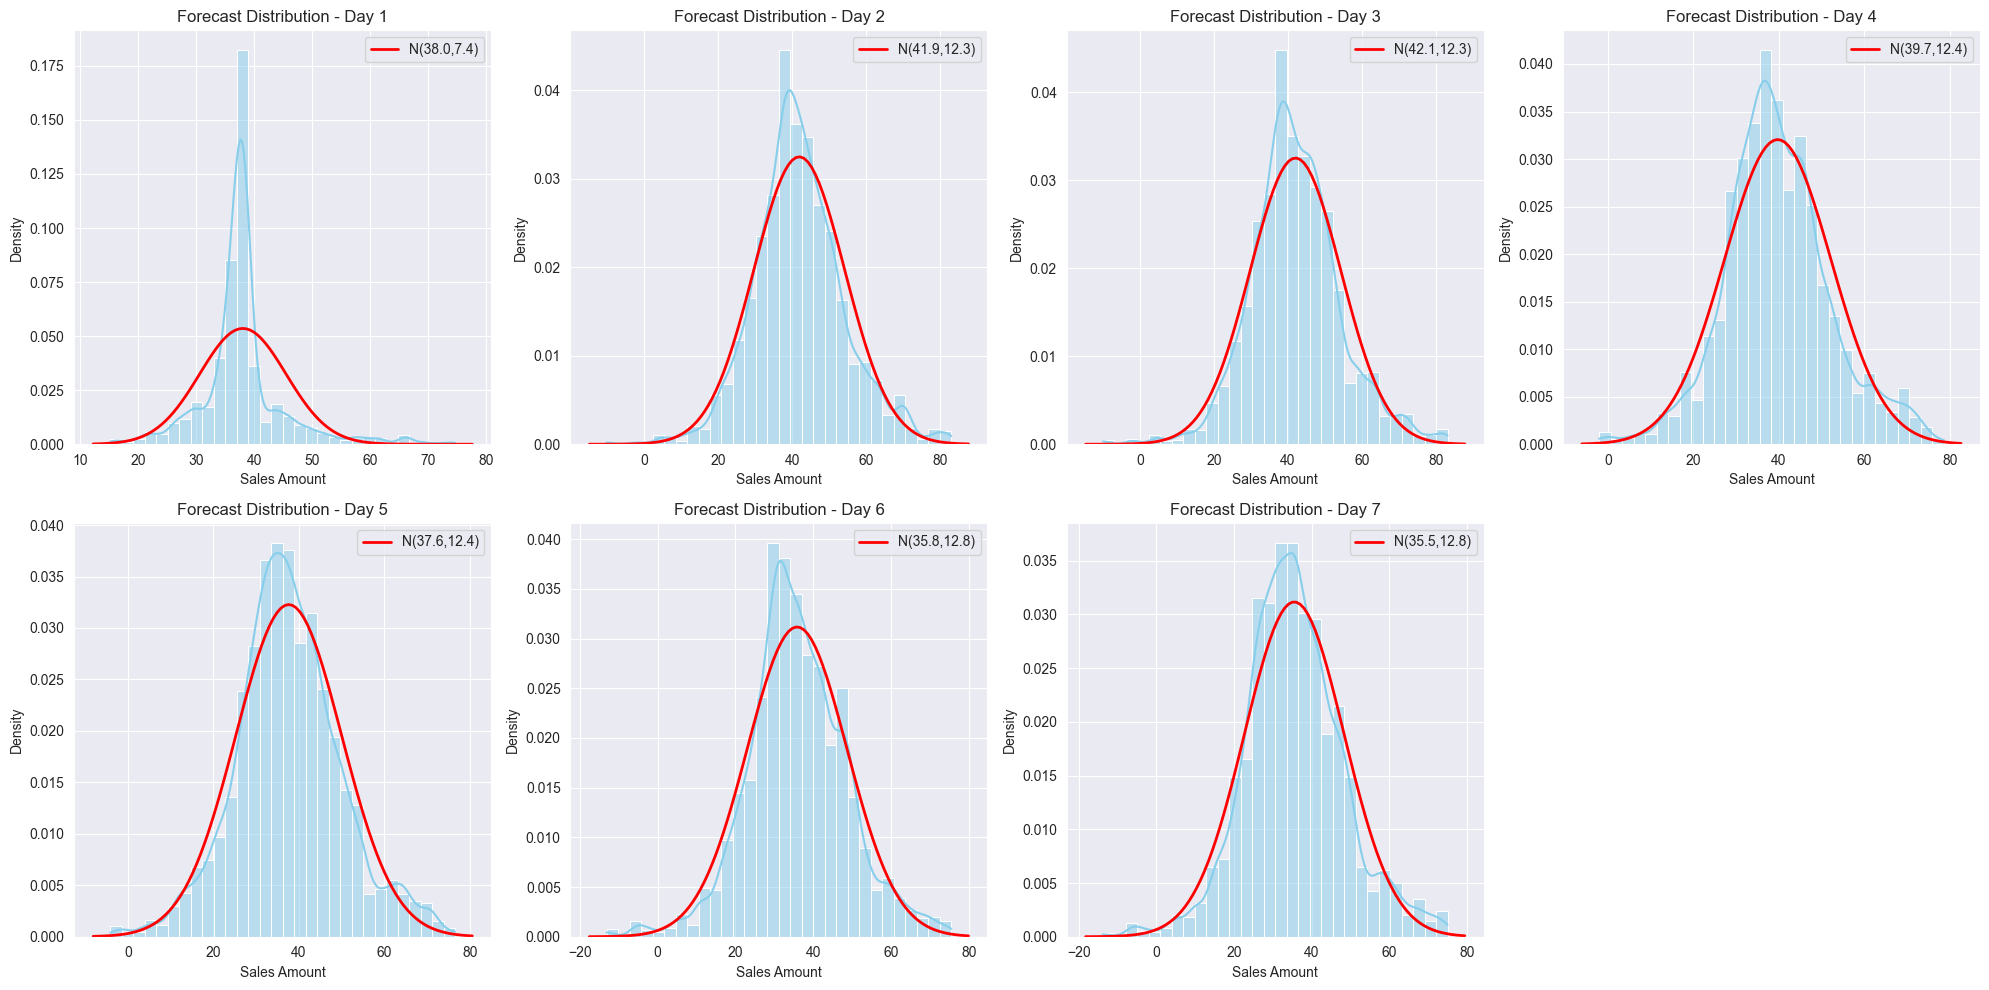

In [367]:
 # -------------------------
# 8. Visualize the Bootstrapped Forecast Distributions
# -------------------------
# Create subplots for each day’s forecast distribution.
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i in range(7):
    samples = bootstrap_forecasts_df[i]
    ax = axes[i]
    sns.histplot(samples, kde=True, ax=ax, stat="density", bins=30, color='skyblue')
    ax.set_title(f"Forecast Distribution - Day {i+1}")
    ax.set_xlabel("Sales Amount")
    ax.set_ylabel("Density")

    mu, std = stats.norm.fit(samples)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2, label=f"N({mu:.1f},{std:.1f})")
    ax.legend()

if len(axes) > 7:
    axes[-1].axis('off')

plt.tight_layout()

save_dir = "Forecasts"
file_path = os.path.join(save_dir, f"Forecasts_{product}_{store}.png")

fig.savefig(file_path)
print(f"Saved forecast distribution plot as {file_path}")

plt.show()

In [368]:
def plot_histogram(data, index):
    mean = np.mean(data)
    std = np.std(data)

    bin_count = int(np.sqrt(len(data)))
    plt.subplot(1,2,1)
    sns.histplot(data=data, bins=bin_count, kde=False, color='blue')
    index += 1
    plt.title(f"Sales Histogram of Day-{index}")
    plt.xlabel("Sales Quantity")
    plt.ylabel("Frequency")

def plot_distribution(data, index):
    mean = np.mean(data)
    std = np.std(data)

    plt.subplot(1,2,2)
    sns.kdeplot(data=data, fill=True, color='red')
    index += 1
    plt.title(f"Sales Distribution of Day-{index}")
    plt.xlabel("Sales Quantity")

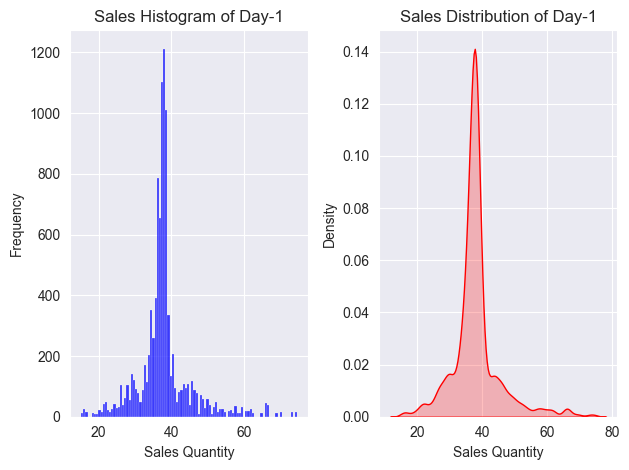

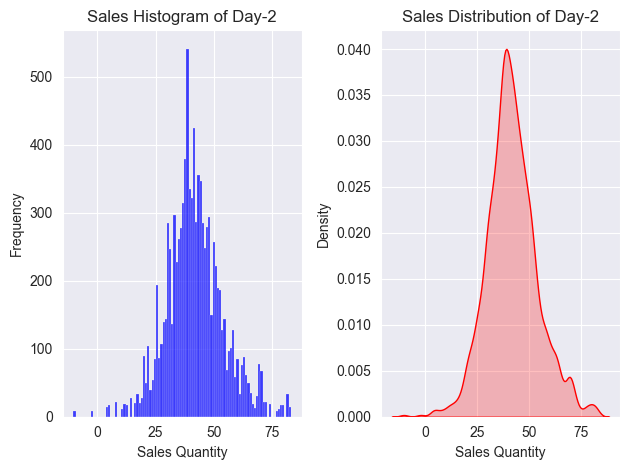

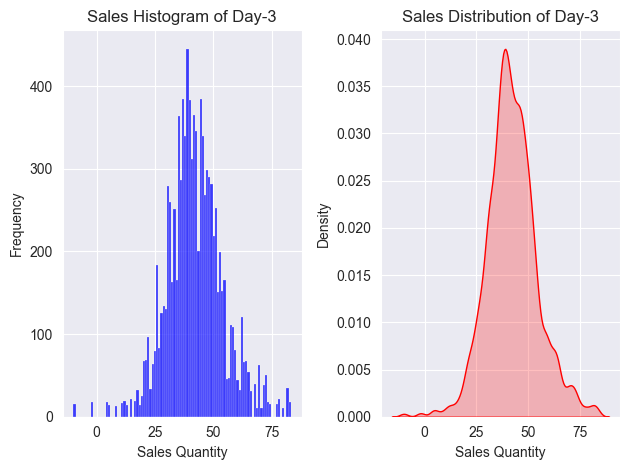

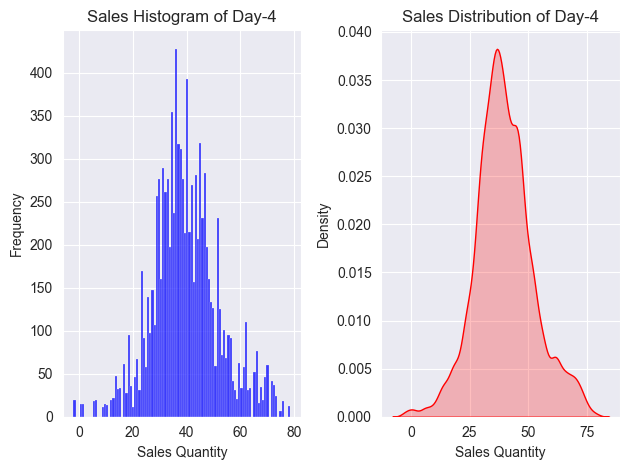

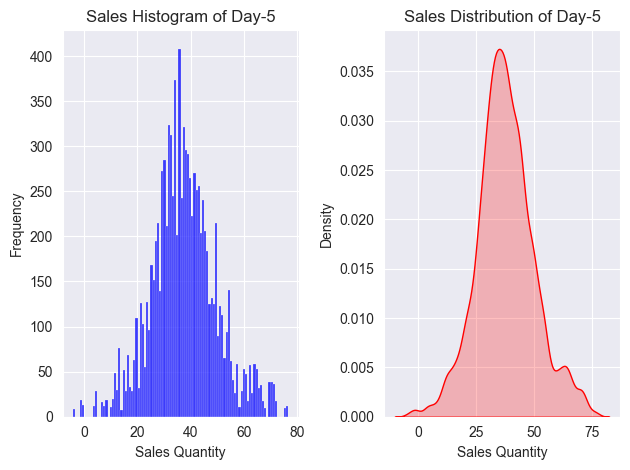

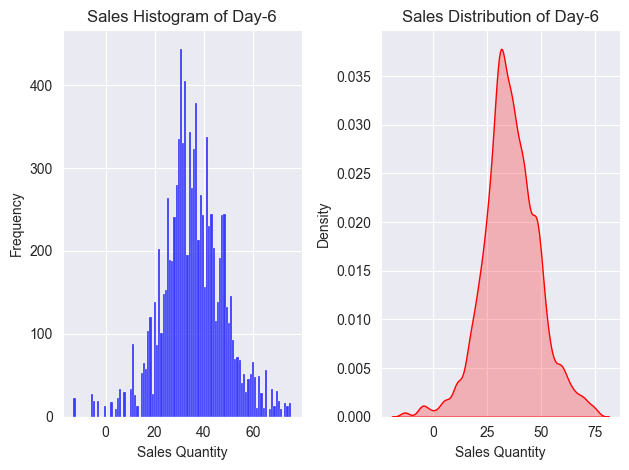

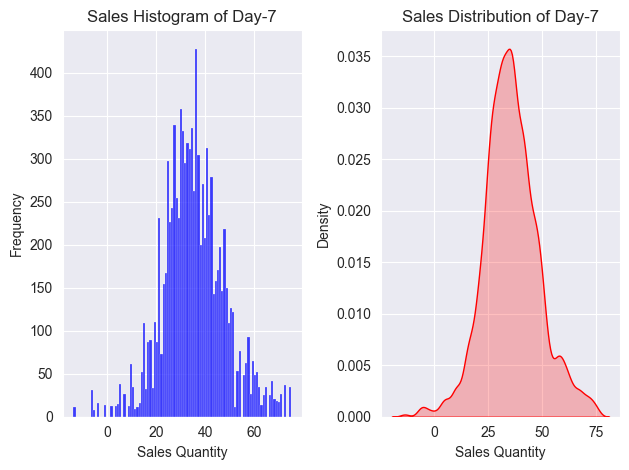

In [369]:
# Plot Histogram & Distribution
i = 0
for col in bootstrap_forecasts_df.columns:
    plot_histogram(bootstrap_forecasts_df[col], i)
    plot_distribution(bootstrap_forecasts_df[col], i)

    plt.tight_layout()
    plt.show()
    i += 1

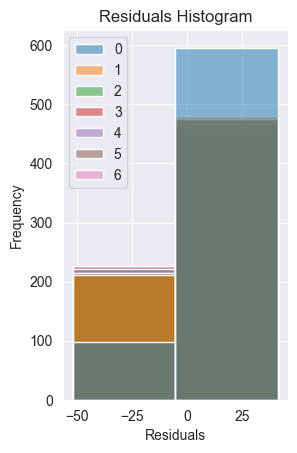

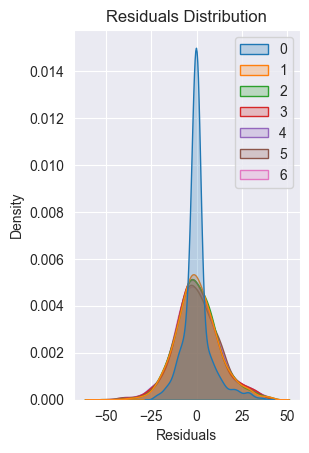

In [370]:
# -------------------------
# 9. Visualize the Residuals
# -------------------------
# Create a histogram plot and a distribution plot for residuals

data = errors_list
bin_count = int(np.sqrt(len(data)))
plt.subplot(1,2,1)
sns.histplot(data=data, bins=bin_count, kde=False, color='blue')
plt.title(f"Residuals Histogram")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

plt.show()

plt.subplot(1,2,2)
sns.kdeplot(data=data, fill=True, color='red')
plt.title(f"Residuals Distribution")
plt.xlabel("Residuals")

plt.show()